<a href="https://colab.research.google.com/github/veiji/machine-learning/blob/feature_engineering/notebooks/Model_Evaluation_and_Dimensionality_Reduction_with_Scikit_Learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learn with us: www.zerotodeeplearning.com

Copyright © 2021: Zero to Deep Learning ® Catalit LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Model Evaluation and Dimensionality Reduction with Scikit Learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = 'https://raw.githubusercontent.com/zerotodeeplearning/ztdl-masterclasses/master/data/'

In [3]:
df = pd.read_csv(url + 'sms.tsv', sep='\t')

In [4]:
df.head()

,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df['label'].value_counts() / len(df)

,count
label,
ham,0.865937
spam,0.134063


In [6]:
y = (df['label'] == 'spam')

### Word count features

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
def cross_val_score_print(model, X, y, cv=3):
    scores = cross_val_score(model, X, y, cv=cv)
    print("Accuracy score: {:0.3} +/- {:0.3}".format(scores.mean(), scores.std()))

In [9]:
vect = CountVectorizer(decode_error='ignore',
                       stop_words='english',
                       binary=True,
                       max_features=2000)

X = vect.fit_transform(df['msg'])

In [10]:
X

<5572x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 34583 stored elements in Compressed Sparse Row format>

Visualize the first 200 word counts in the first 200 messages

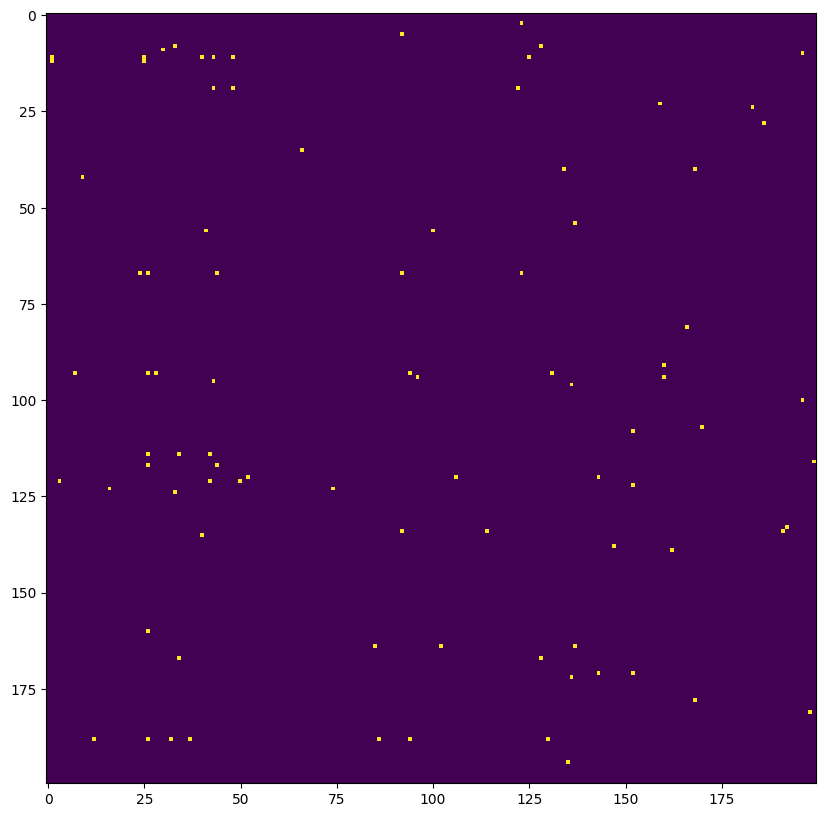

In [11]:
N = 200
plt.figure(figsize=(10, 10))
plt.imshow(X.todense()[:N, :N]);

In [12]:
cross_val_score_print(DummyClassifier(strategy='most_frequent'), X, y)

Accuracy score: 0.866 +/- 3.4e-05


In [13]:
cross_val_score_print(LogisticRegression(solver='liblinear'), X, y)

Accuracy score: 0.979 +/- 0.000675


### Feature importances

The model using 2000 word features seems to be performing quite well. Let's find out which words are more correlated with `Spam`.

The features we are using are counts of word occurrences in a corpus of SMS messages. Since SMSs have a fixed length, we can assume that these counts are proportional to the fequencies of occurrences. In other words we can assume that all the features have the same normalization scale. Under this assumption, we can interpret the coefficients of the `LogisticRegression` model as features importances.

In [16]:
model = LogisticRegression(solver='liblinear')
model.fit(X, y)

LogisticRegression(solver='liblinear')

In [18]:
word_feature_importances = pd.Series(model.coef_[0],
                                     index=vect.get_feature_names_out()).sort_values()

In [19]:
# Top 20 least spammy words
word_feature_importances.head(20)

,0
gt,-1.372524
lt,-1.365823
ok,-0.988278
later,-0.979985
happy,-0.964869
fullonsms,-0.956130
ll,-0.955212
way,-0.912391
da,-0.849973
home,-0.838388


In [20]:
# Top 20 most spammy words
word_feature_importances.tail(20)

,0
0800,1.487548
urgent,1.521464
message,1.535921
www,1.536953
chat,1.598027
min,1.615251
won,1.648403
dating,1.666117
http,1.669242
free,1.690543


### Truncated SVD

A common way to visualize highly dimensional feature sets is to use the Truncated SVD dimensionality reduction technique. Let's use it to compress our 2000 sparse features to a 5 dimensional space.

In [21]:
from sklearn.decomposition import TruncatedSVD

In [22]:
X_tsvd = pd.DataFrame(TruncatedSVD(n_components=5).fit_transform(X), columns=['c1', 'c2', 'c3', 'c4', 'c5'])
X_tsvd['label'] = y

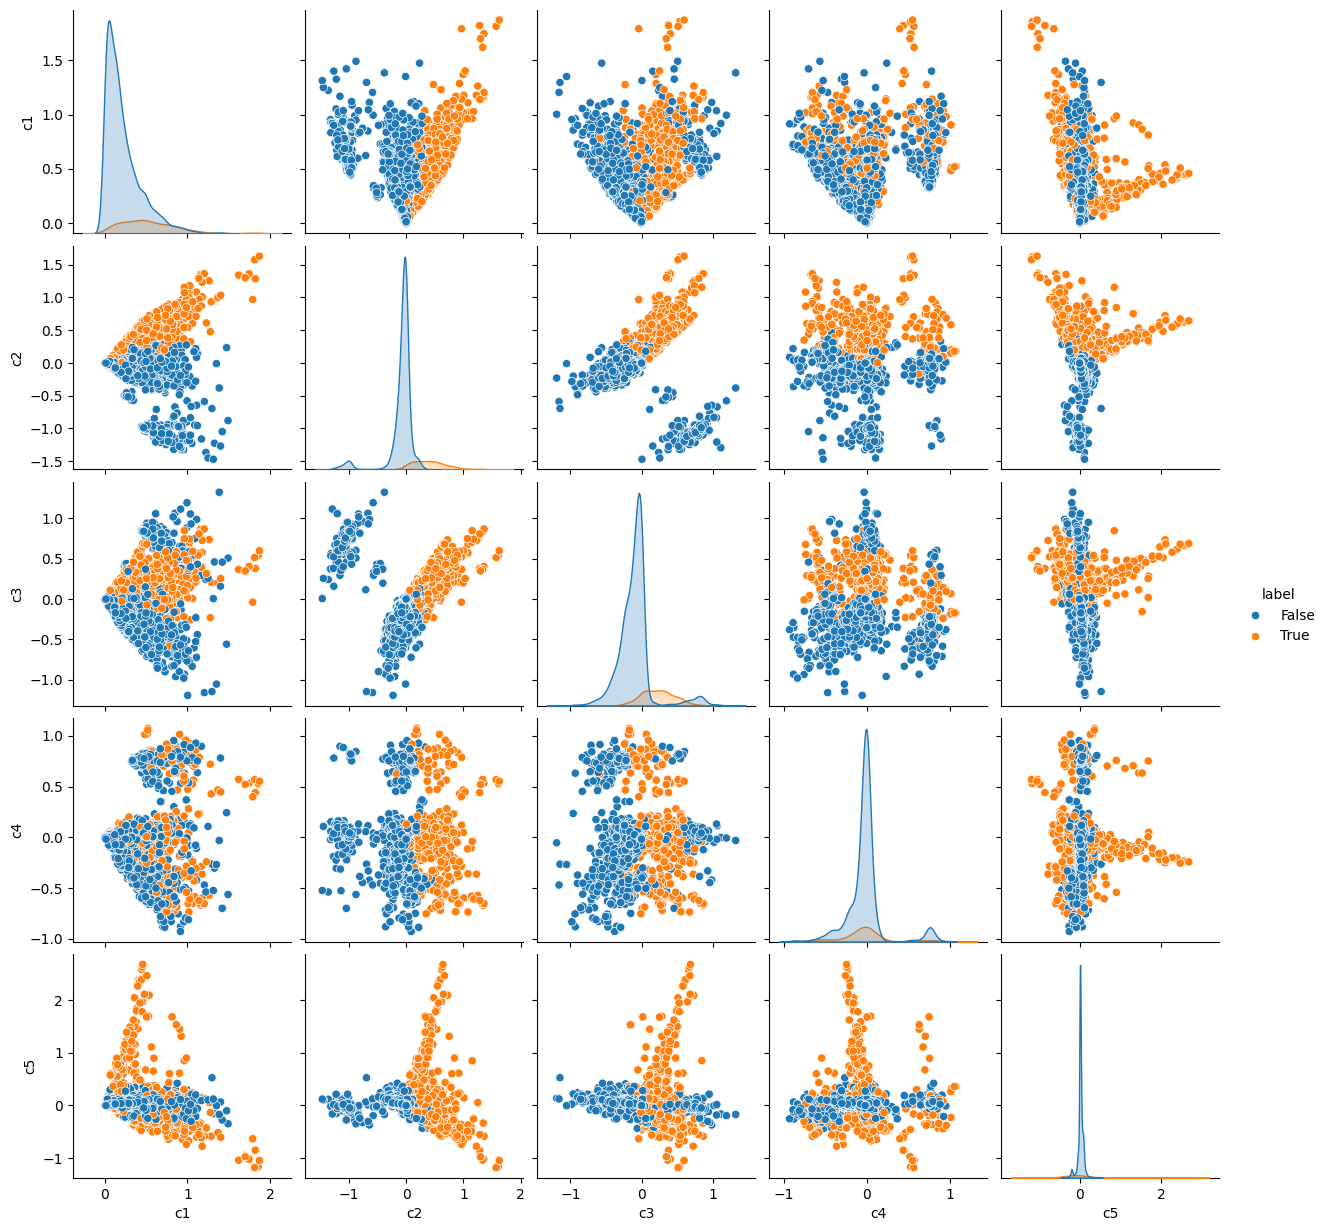

In [23]:
sns.pairplot(X_tsvd, hue='label');

### Exercise 1: Model validation with Pipelines.

When the feature engineering step involves learning something from the data we should only learn from the training set.

In the case above, we are learning the vocabulary from the data, but there are many other cases where the transformer is learning  properties of the data. In these cases, we should proceed with caution and only learn from the training set.

One way to achieve this is to do something like this:

```python
raw_features_train, raw_features_test = train_test_split(....)
transformer = ....

transformer.fit(raw_features_train)
X_train = transformer.transform(raw_features_train)
X_test = transformer.transform(raw_features_test)
```

a better way to achieve the same is to bundle the transformer and the estimator into a [`Pipeline`](https://scikit-learn.org/stable/modules/compose.html).

Complete the following steps:

- Split `df['msg']` and `y` into train and test sets
- Create a pipeline using the `make_pipeline` function that contains at least 2 steps: `vect` and `LogisticRegression()`. Feel free to include additional intermediate steps if you wish
- Train the pipeline model on the trainin set and compare the training and test scores
- Bonus points if you perform Cross Validation


In [24]:
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.pipeline import make_pipeline

In [25]:
msg_train, msg_test, y_train, y_test = train_test_split(df['msg'], y, test_size=0.2, random_state=0)

In [27]:
model = make_pipeline(CountVectorizer(decode_error='ignore',
                                       stop_words='english',
                                       binary=True,
                                       max_features=2000),
                      LogisticRegression(solver='liblinear'))

In [28]:
# here we can see what this pipeline is. First executes the count vectorizer and next the logistic regression.
model.fit(msg_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(binary=True, decode_error='ignore',
                                 max_features=2000, stop_words='english')),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [29]:
model.score(msg_train, y_train)

0.9905766210455463

In [30]:
model.score(msg_test, y_test)

0.9820627802690582

In [34]:
# will train with 70% of data and test with 30%, 10 times. Each time with randomized data.
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

cross_val_score_print(model, df['msg'], y, cv=cv)

Accuracy score: 0.979 +/- 0.00304


### Exercise 2: ROC curve and learning curve

- Use the trained pipeline model to calculate the [`roc_curve`](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)
- Bonus point if you plot it for both train and test sets defined above.
- Use the pipeline model to calculate and plot the [`learning_curve`](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)

### Exercise 3

Let's explore the effect of Dimensionality Reduction techniques on a different dataset: the Digits dataset.

The data is loaded for you.

- Use one or more dimensionality reduction techniques (e.g. `PCA`, `TSNE` or other) to compress the 64 pixel features into 2 features.
- Use `sns.scatterplot` to visualize the whole dataset in the reduced space
- Use the `y` variable to color the data: do you see clusters of similar points appear?

In [ ]:
from sklearn.datasets import load_digits

In [ ]:
X, y = load_digits(return_X_y=True)

In [ ]:
X.shape

In [ ]:
plt.imshow(X[0].reshape(8, 8), cmap='gray');

In [ ]:
plt.imshow(X[1].reshape(8, 8), cmap='gray');